In [76]:
import pandas as pd
import numpy as np
from scipy.stats import skew
import matplotlib.pyplot as plt
import os
import pickle
import heapq
from tempfile import NamedTemporaryFile
from memory_profiler import memory_usage
import time

In [77]:
data = pd.read_csv('Electric_Vehicle_Data.csv')
print(data.head(0))

Empty DataFrame
Columns: [VIN (1-10), County, City, State, Postal Code, Model Year, Make, Model, Electric Vehicle Type, Clean Alternative Fuel Vehicle (CAFV) Eligibility, Electric Range, Base MSRP, Legislative District, DOL Vehicle ID, Vehicle Location, Electric Utility, 2020 Census Tract]
Index: []


Attribute Oriented Induction

In [78]:
state_category = {'WA': [], 'non-WA': []}

for state in data['State']:
    if state == 'WA':
        if state not in state_category['WA']:
            state_category['WA'].append(state)
    else:
        if state not in state_category['non-WA']:
            state_category['non-WA'].append(state)

# Output the dictionary
print(state_category)

{'WA': ['WA'], 'non-WA': ['AE', 'VA', 'NV', 'CA', 'DC', 'MO', 'MD', 'SC', 'PA', 'IL', 'TX', 'NE', 'GA', 'AL', 'WY', 'NC', 'HI', 'CO', 'ID', 'AZ', 'KS', 'FL', 'AR', 'IN', 'BC', 'MN', 'OR', 'OH', 'NY', 'NM', 'UT', 'LA', 'CT', 'MI', 'MA', 'NH', 'OK', 'NJ', 'IA', 'RI', 'KY', 'AK', 'DE']}


In [79]:
model_year_category = {'2023-2024':[],'2020-2022':[],'upto2019':[]}

for model_year in data['Model Year']:
    if model_year == 2023 or model_year == 2024:
        if model_year not in model_year_category['2023-2024']:
            model_year_category['2023-2024'].append(model_year)
    elif model_year >= 2020 and model_year <= 2022:
        if model_year not in model_year_category['2020-2022']:
            model_year_category['2020-2022'].append(model_year)
    else:
        if model_year not in model_year_category['upto2019']:
            model_year_category['upto2019'].append(model_year)

print(model_year_category)

{'2023-2024': [2023, 2024], '2020-2022': [2021, 2020, 2022], 'upto2019': [2017, 2018, 2015, 2013, 2019, 2014, 2016, 2011, 2012, 2010, 2008, 2000, 2002, 1998, 1997, 1999, 2003]}


In [80]:
electric_utility_category = {'BONNEVILLE': [], 'NON-BONNEVILLE': []}

for entry in data['Electric Utility']:
    if isinstance(entry, str):
        name = entry.strip().split("  ")[0]  # Extract the name part
        if name.startswith('BONNEVILLE'):
            if name not in electric_utility_category['BONNEVILLE']:
                electric_utility_category['BONNEVILLE'].append(name)
        else:
            if name not in electric_utility_category['NON-BONNEVILLE']:
                electric_utility_category['NON-BONNEVILLE'].append(name)
    else:
        if 'NON-BONNEVILLE' not in electric_utility_category:
            electric_utility_category['NON-BONNEVILLE'] = []
        electric_utility_category['NON-BONNEVILLE'].append(entry)

print(electric_utility_category)

{'BONNEVILLE': ['BONNEVILLE POWER ADMINISTRATION||PUD NO 1 OF CLARK COUNTY - (WA)', 'BONNEVILLE POWER ADMINISTRATION||PUD NO 1 OF COWLITZ COUNTY', 'BONNEVILLE POWER ADMINISTRATION||PUGET SOUND ENERGY INC||PUD NO 1 OF JEFFERSON COUNTY', 'BONNEVILLE POWER ADMINISTRATION||PACIFICORP||PUD NO 1 OF CLARK COUNTY - (WA)', 'BONNEVILLE POWER ADMINISTRATION||PUD 1 OF SNOHOMISH COUNTY', 'BONNEVILLE POWER ADMINISTRATION||PACIFICORP||BENTON RURAL ELECTRIC ASSN', 'BONNEVILLE POWER ADMINISTRATION||PUD NO 1 OF MASON COUNTY|PUD NO 1 OF JEFFERSON COUNTY', 'BONNEVILLE POWER ADMINISTRATION||CITY OF PORT ANGELES - (WA)', 'BONNEVILLE POWER ADMINISTRATION||PUD NO 1 OF CLALLAM COUNTY', 'BONNEVILLE POWER ADMINISTRATION||PUD NO 1 OF KLICKITAT COUNTY', 'BONNEVILLE POWER ADMINISTRATION||CITY OF MILTON - (WA)|CITY OF TACOMA - (WA)', 'BONNEVILLE POWER ADMINISTRATION||CITY OF TACOMA - (WA)||PENINSULA LIGHT COMPANY', 'BONNEVILLE POWER ADMINISTRATION||PUD NO 1 OF CLALLAM COUNTY|PUD NO 1 OF JEFFERSON COUNTY', 'BONNEVILL

In [81]:
make_continent = {
    'Asia': ['Toyota', 'Nissan', 'Honda', 'Kia', 'Hyundai', 'Mazda', 'Mitsubishi', 'Subaru', 'Lexus', 'Acura', 'Infiniti', 'Genesis'],
    'America': ['Tesla', 'Chevrolet', 'Ford', 'Jeep', 'Chrysler', 'Rivian', 'Dodge', 'Cadillac', 'Lincoln', 'GMC', 'Fisker', 'Wheego Electric Cars'],
    'Europe': ['BMW', 'Volkswagen', 'Volvo', 'Audi', 'Mercedes-Benz', 'Porsche', 'Mini', 'Polestar', 'Fiat', 'Jaguar', 'Land Rover', 'Alfa Romeo', 'Bentley', 'Rolls Royce', 'Smart', 'Lucid', 'Azure Dynamics', 'TH!NK']
}

for continent, makes in make_continent.items():
    make_continent[continent] = [make.upper() for make in makes]

print(make_continent)

{'Asia': ['TOYOTA', 'NISSAN', 'HONDA', 'KIA', 'HYUNDAI', 'MAZDA', 'MITSUBISHI', 'SUBARU', 'LEXUS', 'ACURA', 'INFINITI', 'GENESIS'], 'America': ['TESLA', 'CHEVROLET', 'FORD', 'JEEP', 'CHRYSLER', 'RIVIAN', 'DODGE', 'CADILLAC', 'LINCOLN', 'GMC', 'FISKER', 'WHEEGO ELECTRIC CARS'], 'Europe': ['BMW', 'VOLKSWAGEN', 'VOLVO', 'AUDI', 'MERCEDES-BENZ', 'PORSCHE', 'MINI', 'POLESTAR', 'FIAT', 'JAGUAR', 'LAND ROVER', 'ALFA ROMEO', 'BENTLEY', 'ROLLS ROYCE', 'SMART', 'LUCID', 'AZURE DYNAMICS', 'TH!NK']}


In [82]:
def get_generalized_value(value, hierarchy, hierarchy_type):
    """
    Generalizes the given value based on the provided hierarchy and hierarchy type.
    """ 
    if hierarchy_type == 'make_to_continent':
        for continent, makes in hierarchy.items():
            if value in makes:
                return continent
    elif hierarchy_type == 'state_to_statecategory':
        for category, state in hierarchy.items():
            if value in state:
                return category
    elif hierarchy_type == 'electric_utility_to_category':
        for category, utility in hierarchy.items():
            if value in utility:
                return category
    elif hierarchy_type == 'model_year_to_category':    
        for category, year in hierarchy.items():
            if value in year:
                return category

def generalize_value_recursive(value, hierarchies):
    """
    Recursively generalizes a value across multiple hierarchies.
    """
    for hierarchy_type, hierarchy in hierarchies:
        generalized_value = get_generalized_value(value, hierarchy, hierarchy_type)
        if generalized_value != value:
            value = generalized_value 
    return value

def generalize_attributes(data, concept_hierarchy, T):
    """
    Generalizes the attributes of the DataFrame `data` based on the concept hierarchy and threshold T.
    """
    for attribute in data.columns:
        hierarchies = concept_hierarchy.get(attribute, [])
        
        if not hierarchies:
            if data[attribute].nunique() > T:
                data.drop(columns=[attribute], inplace=True)
        else:
            while data[attribute].nunique() > T:
                data[attribute] = data[attribute].apply(lambda x: generalize_value_recursive(x, hierarchies))

        data.drop_duplicates(inplace=True)
        
    return data

concept_hierarchy = {
    'State' : [
        ('state_to_statecategory', state_category)
    ],
    'Make' : [
        ('make_to_continent', make_continent)
    ],
    'Electric Utility' : [
        ('electric_utility_to_category', electric_utility_category)
    ],
    'Model Year' : [
        ('model_year_to_category', model_year_category)
    ]
}

T = 10


generalized_data = generalize_attributes(data, concept_hierarchy, T)
print(len(generalized_data))
print(generalized_data)


91
         State Model Year     Make                   Electric Vehicle Type  \
0           WA   upto2019   Europe  Plug-in Hybrid Electric Vehicle (PHEV)   
2           WA   upto2019  America          Battery Electric Vehicle (BEV)   
3           WA  2020-2022  America  Plug-in Hybrid Electric Vehicle (PHEV)   
4           WA  2020-2022  America          Battery Electric Vehicle (BEV)   
5           WA  2023-2024  America  Plug-in Hybrid Electric Vehicle (PHEV)   
...        ...        ...      ...                                     ...   
150865  non-WA   upto2019   Europe          Battery Electric Vehicle (BEV)   
155162      WA   upto2019     Asia          Battery Electric Vehicle (BEV)   
158110  non-WA  2023-2024   Europe  Plug-in Hybrid Electric Vehicle (PHEV)   
162508  non-WA  2020-2022   Europe          Battery Electric Vehicle (BEV)   
165105  non-WA  2020-2022   Europe  Plug-in Hybrid Electric Vehicle (PHEV)   

       Clean Alternative Fuel Vehicle (CAFV) Eligibility Ele

Bottom Up Cube

In [83]:
def bottom_up_cube_main(input_data, dim, num_dims, cardinality, minsup, output_rec,output_lis):

    output_lis.append(tuple(map(str, output_rec)))

    for d in range(dim, num_dims):
        C = cardinality[d]

        partitions = counting_sort_partition(input_data, d, C)

        for i in range(C):
            c = len(partitions[i])
            
            if c >= minsup:
                output_rec[d] = partitions[i][0][d]
                bottom_up_cube_main(partitions[i], d + 1, num_dims, cardinality, minsup, output_rec,output_lis)
        
        output_rec[d] = 'ALL'

def counting_sort_partition(input_data, dim, C):
    partitions = [[] for _ in range(C)]
    for record in input_data:
        partitions[record[dim] - 1].append(record)
    return partitions

num_dims = 2
cardinality = [2,2]
minsup = 1
output_rec = ['ALL'] * num_dims  
output_lis=[]
input_data = [
    [1,1],
    [1,2],
    [2,1],
    [2,2],
    [2,2],
    [1,1]
]

bottom_up_cube_main(input_data, 0, num_dims, cardinality, minsup, output_rec,output_lis)

for record in output_lis:
    print(record)


('ALL', 'ALL')
('1', 'ALL')
('1', '1')
('1', '2')
('2', 'ALL')
('2', '1')
('2', '2')
('ALL', '1')
('ALL', '2')


Without ordering

In [84]:
buc_data=pd.read_csv('Electric_Vehicle_Data.csv')
buc_data=buc_data[['State','Clean Alternative Fuel Vehicle (CAFV) Eligibility','Model Year','Make','Electric Utility']]
buc_data=buc_data.dropna()
num_dims=buc_data.shape[1]
cardinality = [buc_data[attribute].nunique() for attribute in buc_data.columns]

minsup = 100
output_rec = ['ALL'] * num_dims
output_lis=[]
input_data = buc_data.values.tolist()

mappings = {attribute: {value: idx + 1 for idx, value in enumerate(buc_data[attribute].unique())} for attribute in buc_data.columns}

for i in range(len(input_data)):
    for j in range(len(input_data[i])):
        input_data[i][j] = mappings[buc_data.columns[j]][input_data[i][j]]

start_time = time.time()
bottom_up_cube_main(input_data, 0, num_dims, cardinality, minsup, output_rec,output_lis)
end_time = time.time()

print("Execution Time: ", end_time - start_time)

print(len(output_lis))

for record in output_lis:
    print(record)

Execution Time:  0.8073935508728027
3755
('ALL', 'ALL', 'ALL', 'ALL', 'ALL')
('1', 'ALL', 'ALL', 'ALL', 'ALL')
('1', '1', 'ALL', 'ALL', 'ALL')
('1', '1', '1', 'ALL', 'ALL')
('1', '1', '1', '1', 'ALL')
('1', '1', '1', '7', 'ALL')
('1', '1', '1', '9', 'ALL')
('1', '1', '1', '9', '1')
('1', '1', '1', '9', '2')
('1', '1', '1', '9', '5')
('1', '1', '1', '10', 'ALL')
('1', '1', '1', '10', '2')
('1', '1', '1', '10', '5')
('1', '1', '1', '11', 'ALL')
('1', '1', '1', 'ALL', '1')
('1', '1', '1', 'ALL', '2')
('1', '1', '1', 'ALL', '5')
('1', '1', '1', 'ALL', '8')
('1', '1', '1', 'ALL', '22')
('1', '1', '2', 'ALL', 'ALL')
('1', '1', '2', '1', 'ALL')
('1', '1', '2', '5', 'ALL')
('1', '1', '2', '7', 'ALL')
('1', '1', '2', '9', 'ALL')
('1', '1', '2', '9', '1')
('1', '1', '2', '9', '2')
('1', '1', '2', '9', '5')
('1', '1', '2', '10', 'ALL')
('1', '1', '2', '11', 'ALL')
('1', '1', '2', '11', '5')
('1', '1', '2', '21', 'ALL')
('1', '1', '2', 'ALL', '1')
('1', '1', '2', 'ALL', '2')
('1', '1', '2', 'ALL',

Ordering Based on Information gain

In [91]:
buc_data=pd.read_csv('Electric_Vehicle_Data.csv')
buc_data=buc_data[['State','Clean Alternative Fuel Vehicle (CAFV) Eligibility','Model Year','Make','Electric Utility']]
buc_data=buc_data.dropna()

total_size = buc_data.shape[0]
probabilities = [{attribute: (buc_data[attribute].value_counts() / total_size).to_dict()} for attribute in buc_data.columns]

def entropy(probabilities):
    return -sum(p * np.log2(p) for p in probabilities if p > 0)

def information_gain(data, split_attribute, target_attribute):
    total_entropy = entropy((data[target_attribute].value_counts() / len(data)).values)
    
    values = data[split_attribute].unique()
    weighted_entropy = 0
    for value in values:
        subset = data[data[split_attribute] == value]
        weighted_entropy += (len(subset) / len(data)) * entropy((subset[target_attribute].value_counts() / len(subset)).values)
    
    return total_entropy - weighted_entropy

overall_info_gains = {attribute: 0 for attribute in buc_data.columns}

for target_attribute in buc_data.columns:
    for attribute in buc_data.columns:
        if attribute != target_attribute:
            overall_info_gains[attribute] += information_gain(buc_data, attribute, target_attribute)


print("Overall Information Gains:")
for attribute, gain in overall_info_gains.items():
    print(f"{attribute}: {gain:.4f}")

sorted_attributes = sorted(overall_info_gains, key=overall_info_gains.get, reverse=True)

Overall Information Gains:
State: 0.0266
Clean Alternative Fuel Vehicle (CAFV) Eligibility: 1.0762
Model Year: 1.0072
Make: 0.8850
Electric Utility: 0.1016


In [93]:
buc_data = pd.read_csv('Electric_Vehicle_Data.csv')
buc_data=buc_data.dropna()
buc_data=buc_data[sorted_attributes]
num_dims=buc_data.shape[1]
cardinality = [buc_data[attribute].nunique() for attribute in buc_data.columns]

minsup = 100
output_rec = ['ALL'] * num_dims
output_lis=[]
input_data = buc_data.values.tolist()

mappings = {attribute: {value: idx + 1 for idx, value in enumerate(buc_data[attribute].unique())} for attribute in buc_data.columns}

for i in range(len(input_data)):
    for j in range(len(input_data[i])):
        input_data[i][j] = mappings[buc_data.columns[j]][input_data[i][j]]

start_time = time.time()
bottom_up_cube_main(input_data, 0, num_dims, cardinality, minsup, output_rec,output_lis)
end_time = time.time()

print("Execution Time: ", end_time - start_time)

print(len(output_lis))

for record in output_lis:
    print(record)

Execution Time:  0.6627061367034912
3748
('ALL', 'ALL', 'ALL', 'ALL', 'ALL')
('1', 'ALL', 'ALL', 'ALL', 'ALL')
('1', '1', 'ALL', 'ALL', 'ALL')
('1', '1', '1', 'ALL', 'ALL')
('1', '1', '1', 'ALL', '1')
('1', '1', '7', 'ALL', 'ALL')
('1', '1', '7', 'ALL', '1')
('1', '1', '9', 'ALL', 'ALL')
('1', '1', '9', '1', 'ALL')
('1', '1', '9', '1', '1')
('1', '1', '9', '2', 'ALL')
('1', '1', '9', '2', '1')
('1', '1', '9', '5', 'ALL')
('1', '1', '9', '5', '1')
('1', '1', '9', 'ALL', '1')
('1', '1', '10', 'ALL', 'ALL')
('1', '1', '10', '2', 'ALL')
('1', '1', '10', '2', '1')
('1', '1', '10', '5', 'ALL')
('1', '1', '10', '5', '1')
('1', '1', '10', 'ALL', '1')
('1', '1', '11', 'ALL', 'ALL')
('1', '1', '11', 'ALL', '1')
('1', '1', 'ALL', '1', 'ALL')
('1', '1', 'ALL', '1', '1')
('1', '1', 'ALL', '2', 'ALL')
('1', '1', 'ALL', '2', '1')
('1', '1', 'ALL', '5', 'ALL')
('1', '1', 'ALL', '5', '1')
('1', '1', 'ALL', '8', 'ALL')
('1', '1', 'ALL', '8', '1')
('1', '1', 'ALL', '22', 'ALL')
('1', '1', 'ALL', '22', '1

Ordering based on cardinality

In [87]:
buc_data = pd.read_csv('Electric_Vehicle_Data.csv')
buc_data = buc_data[['State', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Model Year', 'Make', 'Electric Utility']]
buc_data = buc_data.dropna()

cardinality = {attribute: buc_data[attribute].nunique() for attribute in buc_data.columns}

sorted_attributes = sorted(cardinality, key=cardinality.get, reverse=True)

print("Cardinality:")
for attribute, card in cardinality.items():
    print(f"{attribute}: {card}")

print(f"\nAttributes sorted by cardinality: {sorted_attributes}")

Cardinality:
State: 42
Clean Alternative Fuel Vehicle (CAFV) Eligibility: 3
Model Year: 22
Make: 40
Electric Utility: 76

Attributes sorted by cardinality: ['Electric Utility', 'State', 'Make', 'Model Year', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility']


In [88]:
buc_data = pd.read_csv('Electric_Vehicle_Data.csv')
buc_data=buc_data.dropna()
buc_data=buc_data[sorted_attributes]
num_dims=buc_data.shape[1]
cardinality = [buc_data[attribute].nunique() for attribute in buc_data.columns]

minsup = 100
output_rec = ['ALL'] * num_dims
output_lis=[]
input_data = buc_data.values.tolist()

mappings = {attribute: {value: idx + 1 for idx, value in enumerate(buc_data[attribute].unique())} for attribute in buc_data.columns}

for i in range(len(input_data)):
    for j in range(len(input_data[i])):
        input_data[i][j] = mappings[buc_data.columns[j]][input_data[i][j]]

start_time = time.time()
bottom_up_cube_main(input_data, 0, num_dims, cardinality, minsup, output_rec,output_lis)
end_time = time.time()

print("Execution Time: ", end_time - start_time)

print(len(output_lis))

for record in output_lis:
    print(record)

Execution Time:  0.7240135669708252
3748
('ALL', 'ALL', 'ALL', 'ALL', 'ALL')
('1', 'ALL', 'ALL', 'ALL', 'ALL')
('1', '1', 'ALL', 'ALL', 'ALL')
('1', '1', '1', 'ALL', 'ALL')
('1', '1', '1', '3', 'ALL')
('1', '1', '1', '5', 'ALL')
('1', '1', '1', '5', '3')
('1', '1', '1', '6', 'ALL')
('1', '1', '1', '9', 'ALL')
('1', '1', '1', '9', '2')
('1', '1', '1', '12', 'ALL')
('1', '1', '1', '12', '3')
('1', '1', '1', 'ALL', '1')
('1', '1', '1', 'ALL', '2')
('1', '1', '1', 'ALL', '3')
('1', '1', '2', 'ALL', 'ALL')
('1', '1', '2', '1', 'ALL')
('1', '1', '2', '1', '2')
('1', '1', '2', '2', 'ALL')
('1', '1', '2', '2', '2')
('1', '1', '2', '3', 'ALL')
('1', '1', '2', '3', '3')
('1', '1', '2', '4', 'ALL')
('1', '1', '2', '4', '2')
('1', '1', '2', '5', 'ALL')
('1', '1', '2', '5', '3')
('1', '1', '2', '6', 'ALL')
('1', '1', '2', '6', '3')
('1', '1', '2', '7', 'ALL')
('1', '1', '2', '7', '2')
('1', '1', '2', '8', 'ALL')
('1', '1', '2', '8', '2')
('1', '1', '2', '9', 'ALL')
('1', '1', '2', '9', '2')
('1', '

Ordering based on Skewness

In [89]:
buc_data = pd.read_csv('Electric_Vehicle_Data.csv')
buc_data = buc_data[['State', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Model Year', 'Make', 'Electric Utility']]
buc_data = buc_data.dropna()

skewness = {attribute: skew(buc_data[attribute].value_counts()) for attribute in buc_data.columns}

sorted_attributes = sorted(skewness, key=skewness.get, reverse=True)

print("Skewness:")
for attribute, skew_value in skewness.items():
    print(f"{attribute}: {skew_value:.4f}")

print(f"\nAttributes sorted by skewness: {sorted_attributes}")

Skewness:
State: 6.2469
Clean Alternative Fuel Vehicle (CAFV) Eligibility: -0.2989
Model Year: 2.6235
Make: 5.3707
Electric Utility: 5.4226

Attributes sorted by skewness: ['State', 'Electric Utility', 'Make', 'Model Year', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility']


In [90]:
buc_data = pd.read_csv('Electric_Vehicle_Data.csv')
buc_data=buc_data.dropna()
buc_data=buc_data[sorted_attributes]
num_dims=buc_data.shape[1]
cardinality = [buc_data[attribute].nunique() for attribute in buc_data.columns]

minsup = 100
output_rec = ['ALL'] * num_dims
output_lis=[]
input_data = buc_data.values.tolist()

mappings = {attribute: {value: idx + 1 for idx, value in enumerate(buc_data[attribute].unique())} for attribute in buc_data.columns}

for i in range(len(input_data)):
    for j in range(len(input_data[i])):
        input_data[i][j] = mappings[buc_data.columns[j]][input_data[i][j]]

start_time = time.time()
bottom_up_cube_main(input_data, 0, num_dims, cardinality, minsup, output_rec,output_lis)
end_time = time.time()

print("Execution Time: ", end_time - start_time)

print(len(output_lis))

for record in output_lis:
    print(record)

Execution Time:  0.6671419143676758
3748
('ALL', 'ALL', 'ALL', 'ALL', 'ALL')
('1', 'ALL', 'ALL', 'ALL', 'ALL')
('1', '1', 'ALL', 'ALL', 'ALL')
('1', '1', '1', 'ALL', 'ALL')
('1', '1', '1', '3', 'ALL')
('1', '1', '1', '5', 'ALL')
('1', '1', '1', '5', '3')
('1', '1', '1', '6', 'ALL')
('1', '1', '1', '9', 'ALL')
('1', '1', '1', '9', '2')
('1', '1', '1', '12', 'ALL')
('1', '1', '1', '12', '3')
('1', '1', '1', 'ALL', '1')
('1', '1', '1', 'ALL', '2')
('1', '1', '1', 'ALL', '3')
('1', '1', '2', 'ALL', 'ALL')
('1', '1', '2', '1', 'ALL')
('1', '1', '2', '1', '2')
('1', '1', '2', '2', 'ALL')
('1', '1', '2', '2', '2')
('1', '1', '2', '3', 'ALL')
('1', '1', '2', '3', '3')
('1', '1', '2', '4', 'ALL')
('1', '1', '2', '4', '2')
('1', '1', '2', '5', 'ALL')
('1', '1', '2', '5', '3')
('1', '1', '2', '6', 'ALL')
('1', '1', '2', '6', '3')
('1', '1', '2', '7', 'ALL')
('1', '1', '2', '7', '2')
('1', '1', '2', '8', 'ALL')
('1', '1', '2', '8', '2')
('1', '1', '2', '9', 'ALL')
('1', '1', '2', '9', '2')
('1', '

Paging

In [16]:
pages = 2

def count_rows_in_csv(file_path):
    with open(file_path, 'r') as file:
        row_count = sum(1 for row in file) - 1  # Subtract 1 for the header
    return row_count

total_size = count_rows_in_csv('Electric_Vehicle_Data.csv')

chunk_size = total_size // pages

def load_data_in_chunks(file_path, chunk_size):
    data = pd.read_csv(file_path, chunksize=chunk_size)
    for chunk in data:
        yield chunk

buc_data_paging = load_data_in_chunks('Electric_Vehicle_Data.csv', chunk_size)

unique_values = {
    'State': set(),
    'Clean Alternative Fuel Vehicle (CAFV) Eligibility': set(),
    'Model Year': set(),
    'Make': set(),
    'Electric Utility': set()
}

for i, chunk in enumerate(buc_data_paging):
    chunk = chunk[['State','Clean Alternative Fuel Vehicle (CAFV) Eligibility','Model Year','Make','Electric Utility']]
    chunk = chunk.dropna()
    num_dims = chunk.shape[1]
    for column in unique_values.keys():
        unique_values[column].update(chunk[column].unique())
    
mappings = {column: {value: idx + 1 for idx, value in enumerate(sorted(values))} for column, values in unique_values.items()}
cardinality = [len(values) for values in mappings.values()]

output_set=set()

buc_data_paging = load_data_in_chunks('Electric_Vehicle_Data.csv', chunk_size)

for page,chunk in enumerate(buc_data_paging):
    chunk = chunk[['State','Clean Alternative Fuel Vehicle (CAFV) Eligibility','Model Year','Make','Electric Utility']]
    chunk = chunk.dropna()
    num_dims = chunk.shape[1]
    minsup = 100
    output_rec = ['ALL'] * num_dims
    output_lis=[]
    input_data = chunk.values.tolist()

    for i in range(len(input_data)):
        for j in range(len(input_data[i])):
            input_data[i][j] = mappings[chunk.columns[j]][input_data[i][j]]

    bottom_up_cube_main(input_data, 0, num_dims, cardinality, minsup, output_rec,output_lis)
    print(f'Page {page + 1}: {len(output_lis)}')

    output_set.update(output_lis)
 
print(len(output_set))
for record in output_set:
    print(record)


Page 1: 2256
Page 2: 2502
3048
('ALL', 'ALL', '14', 'ALL', '20')
('41', 'ALL', '20', '12', '58')
('ALL', '2', 'ALL', '16', '37')
('41', '1', '22', 'ALL', '75')
('ALL', '2', '20', 'ALL', '76')
('41', '2', '21', '25', '75')
('41', '1', '19', '5', 'ALL')
('41', '3', '17', '37', 'ALL')
('41', 'ALL', 'ALL', '7', '75')
('ALL', '2', '19', 'ALL', '58')
('ALL', 'ALL', 'ALL', '28', '75')
('41', '1', 'ALL', '35', '34')
('41', '2', '21', '26', 'ALL')
('41', '2', '21', '35', '74')
('41', '3', '13', 'ALL', '75')
('ALL', 'ALL', '22', '19', '75')
('41', 'ALL', 'ALL', '35', 'ALL')
('41', '2', 'ALL', '2', '74')
('ALL', '1', '10', 'ALL', '74')
('41', '1', 'ALL', '38', 'ALL')
('41', '2', 'ALL', '29', 'ALL')
('ALL', 'ALL', 'ALL', '39', '58')
('41', '1', '17', '35', '75')
('41', '1', '16', 'ALL', 'ALL')
('ALL', '1', 'ALL', 'ALL', '41')
('ALL', 'ALL', 'ALL', '26', '74')
('ALL', '2', '20', 'ALL', '62')
('41', '1', '17', 'ALL', '75')
('41', '1', '22', '5', 'ALL')
('ALL', 'ALL', 'ALL', '12', '37')
('ALL', '1', 

Partioning with External Sorting

In [17]:
input_file = 'Electric_Vehicle_Data.csv'
chunk_size = 10000  
mappings = {}

output_file = 'input_data.pkl'

def process_data(chunk_size):
    with open(output_file, 'wb') as out_f:
        for chunk in pd.read_csv(input_file, chunksize=chunk_size):
            chunk = chunk[[ 'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Model Year', 'Make', 'Electric Utility','State']]
            chunk = chunk.dropna()

            for attribute in chunk.columns:
                if attribute not in mappings:
                    mappings[attribute] = {}
                for value in chunk[attribute].unique():
                    if value not in mappings[attribute]:
                        mappings[attribute][value] = len(mappings[attribute]) + 1

            mapped_data = []
            for _, row in chunk.iterrows():
                mapped_row = [mappings[attribute][row[attribute]] for attribute in chunk.columns]
                mapped_data.append(mapped_row)

            pickle.dump(mapped_data, out_f)


process_data(chunk_size)
num_dims = len(mappings)
cardinality = [len(mappings[attribute]) for attribute in mappings]
print(f"Number of dimensions: {num_dims}")
print(f"Cardinality: {cardinality}")

Number of dimensions: 5
Cardinality: [3, 22, 40, 76, 42]


In [18]:
def external_sort(input_file, dim):
    sorted_chunks = []
    with open(input_file, 'rb') as f:
        while True:
            try:
                chunk = pickle.load(f)
                chunk.sort(key=lambda x: x[dim])
                temp_file = NamedTemporaryFile(delete=False)
                with open(temp_file.name, 'wb') as temp_f:
                    pickle.dump(chunk, temp_f)
                sorted_chunks.append(temp_file.name)
            except EOFError:
                break
    return sorted_chunks

def merge_sorted_chunks(sorted_chunks, output_file):
    min_heap = []
    chunk_files = [open(chunk, 'rb') for chunk in sorted_chunks]
    chunk_iters = [iter(pickle.load(chunk_file)) for chunk_file in chunk_files]

    for i, chunk_iter in enumerate(chunk_iters):
        try:
            item = next(chunk_iter)
            heapq.heappush(min_heap, (item, i))
        except StopIteration:
            pass

    with open(output_file, 'wb') as out_f:
        while min_heap:
            smallest, i = heapq.heappop(min_heap)
            pickle.dump([smallest], out_f)
            try:
                item = next(chunk_iters[i])
                heapq.heappush(min_heap, (item, i))
            except StopIteration:
                pass

    for chunk_file in chunk_files:
        chunk_file.close()
        os.remove(chunk_file.name)

In [19]:
def bottom_up_cube_main2(input_file, dim, num_dims, cardinality, minsup, output_rec, output_lis, external=True):
    output_lis.append(tuple(map(str, output_rec)))

    for d in range(dim, num_dims):
        sorted_chunks = external_sort(input_file, d)
        sorted_file = 'sorted_data.pkl'
        merge_sorted_chunks(sorted_chunks, sorted_file)
        C = cardinality[d]
        datacounts = [0] * C
        with open(sorted_file, 'rb') as f:
            while True:
                try:
                    chunk = pickle.load(f)
                    for record in chunk:
                        datacounts[record[d] - 1] += 1
                except EOFError:
                    break
        k = 0
        for i in range(C):
            c = datacounts[i]
            if c >= minsup:
                output_rec[d] = i + 1
                partition_data = []
                with open(sorted_file, 'rb') as f:
                    while True:
                        try:
                            chunk = pickle.load(f)
                            for record in chunk:
                                if record[d] == i + 1:
                                    partition_data.append(record)
                        except EOFError:
                            break
                bottom_up_cube_main(partition_data, d + 1, num_dims, cardinality, minsup, output_rec, output_lis)
            k += c
        output_rec[d] = 'ALL'


output_lis = []
output_rec = ['ALL'] * num_dims
minsup = 100

process_data(chunk_size)
bottom_up_cube_main2(output_file, 0, num_dims, cardinality, minsup, output_rec, output_lis)

print(len(output_lis))
for record in output_lis:
    print(record)

3755
('ALL', 'ALL', 'ALL', 'ALL', 'ALL')
('1', 'ALL', 'ALL', 'ALL', 'ALL')
('1', '1', 'ALL', 'ALL', 'ALL')
('1', '1', '1', 'ALL', 'ALL')
('1', '1', '1', 'ALL', '1')
('1', '1', '7', 'ALL', 'ALL')
('1', '1', '7', 'ALL', '1')
('1', '1', '9', 'ALL', 'ALL')
('1', '1', '9', '1', 'ALL')
('1', '1', '9', '1', '1')
('1', '1', '9', '2', 'ALL')
('1', '1', '9', '2', '1')
('1', '1', '9', '5', 'ALL')
('1', '1', '9', '5', '1')
('1', '1', '9', 'ALL', '1')
('1', '1', '10', 'ALL', 'ALL')
('1', '1', '10', '2', 'ALL')
('1', '1', '10', '2', '1')
('1', '1', '10', '5', 'ALL')
('1', '1', '10', '5', '1')
('1', '1', '10', 'ALL', '1')
('1', '1', '11', 'ALL', 'ALL')
('1', '1', '11', 'ALL', '1')
('1', '1', 'ALL', '1', 'ALL')
('1', '1', 'ALL', '1', '1')
('1', '1', 'ALL', '2', 'ALL')
('1', '1', 'ALL', '2', '1')
('1', '1', 'ALL', '5', 'ALL')
('1', '1', 'ALL', '5', '1')
('1', '1', 'ALL', '8', 'ALL')
('1', '1', 'ALL', '8', '1')
('1', '1', 'ALL', '22', 'ALL')
('1', '1', 'ALL', '22', '1')
('1', '1', 'ALL', 'ALL', '1')
('1

Plots

Minsup vs Runtime

minsup: 10, runtime: 27.082531213760376 seconds
minsup: 50, runtime: 22.78603959083557 seconds
minsup: 100, runtime: 22.153597116470337 seconds
minsup: 200, runtime: 20.987779140472412 seconds
minsup: 500, runtime: 16.24998688697815 seconds
minsup: 1000, runtime: 13.316395044326782 seconds


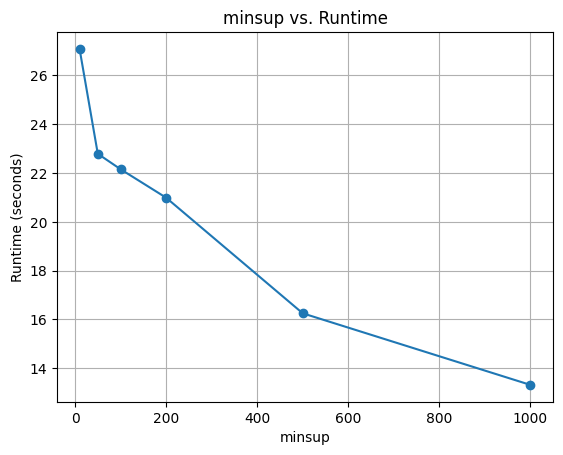

In [20]:
def measure_runtime(minsup_values):
    runtimes = []
    for minsup in minsup_values:
        output_lis = []
        output_rec = ['ALL'] * num_dims
        start_time = time.time()
        bottom_up_cube_main2(output_file, 0, num_dims, cardinality, minsup, output_rec, output_lis)
        end_time = time.time()
        runtime = end_time - start_time
        runtimes.append(runtime)
        print(f"minsup: {minsup}, runtime: {runtime} seconds")
    return runtimes

minsup_values = [10, 50, 100, 200, 500, 1000]

runtimes = measure_runtime(minsup_values)

plt.plot(minsup_values, runtimes, marker='o')
plt.xlabel('minsup')
plt.ylabel('Runtime (seconds)')
plt.title('minsup vs. Runtime')
plt.grid(True)
plt.show()

Memory vs Runtime

chunk_size: 500, runtime: 33.75004839897156 seconds
chunk_size: 1000, runtime: 27.47516894340515 seconds
chunk_size: 5000, runtime: 23.016249179840088 seconds
chunk_size: 10000, runtime: 22.486637830734253 seconds
chunk_size: 20000, runtime: 22.08658194541931 seconds
chunk_size: 50000, runtime: 21.885950803756714 seconds


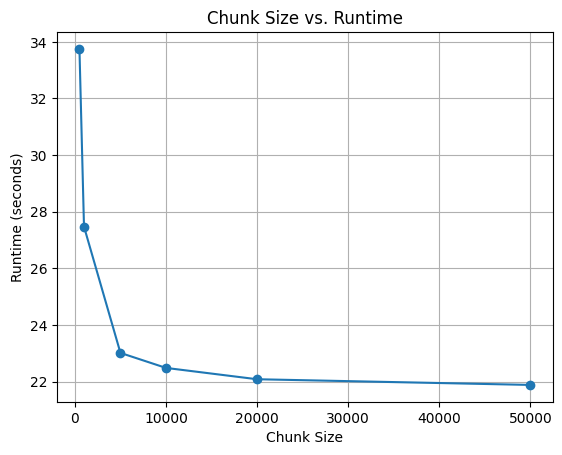

In [22]:
def measure_memory_runtime(chunk_sizes, minsup):
    runtimes = []
    for chunk_size in chunk_sizes:
        process_data(chunk_size)
        output_lis = []
        output_rec = ['ALL'] * num_dims
        start_time = time.time()
        bottom_up_cube_main2(output_file, 0, num_dims, cardinality, minsup, output_rec, output_lis)
        end_time = time.time()
        runtime = end_time - start_time
        runtimes.append(runtime)
        print(f"chunk_size: {chunk_size}, runtime: {runtime} seconds")
    return runtimes

chunk_sizes = [500, 1000, 5000, 10000, 20000, 50000]

minsup = 100

runtimes = measure_memory_runtime(chunk_sizes, minsup)

plt.plot(chunk_sizes, runtimes, marker='o')
plt.xlabel('Chunk Size')
plt.ylabel('Runtime (seconds)')
plt.title('Chunk Size vs. Runtime')
plt.grid(True)
plt.show()